In [10]:
# ライブラリのインポート
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_absolute_error, mean_squared_error
from torch.utils.data import DataLoader
from typing import List, Dict, Tuple

import importlib
import utils.preprocess
import utils.baseline
import utils.model
importlib.reload(utils.preprocess)
importlib.reload(utils.baseline)
importlib.reload(utils.model)

from utils.preprocess import DataWindow
from utils.baseline import Baseline, MultiStepBaseline, RepeatBaseline
from utils.model import LSTMModel, ModelTrainer

import warnings
warnings.filterwarnings('ignore')

torch.manual_seed(42)
np.random.seed(42)

In [2]:
# データのダウンロード
train_df = pd.read_csv('../data/train.csv', index_col=0)
val_df = pd.read_csv('../data/val.csv', index_col=0)
test_df = pd.read_csv('../data/test.csv', index_col=0)

In [8]:
# モデルのコンパイルと訓練を行う関数を定義
def compile_and_fit(model: nn.Module, train_loader: DataLoader, val_loader: DataLoader, 
                    criterion: nn.Module, optimizer: optim.Optimizer, 
                    device: torch.device, max_epochs: int = 50, patience: int = 3) -> Dict[str, List[float]]:
    """
    モデルのコンパイルとトレーニング。

    引数:
        model (nn.Module): 学習モデル。
        train_loader (DataLoader): 訓練データローダー。
        val_loader (DataLoader): 検証データローダー。
        criterion (nn.Module): 損失関数。
        optimizer (optim.Optimizer): オプティマイザ。
        device (torch.device): 実行環境。
        max_epochs (int): 最大エポック数。
        patience (int): 早期停止のエポック数。

    戻り値:
        Dict[str, List[float]]: トレーニングおよび検証損失の履歴。
    """
    trainer = ModelTrainer(model, train_loader, val_loader, criterion, optimizer, device)
    return trainer.train(max_epochs=max_epochs, patience=patience)

# モデルの評価関数を定義
def evaluate(model: nn.Module, data_loader: DataLoader, criterion: nn.Module, device: torch.device) -> float:
    """
    モデルの評価関数。

    引数:
        model (nn.Module): 学習済みモデル。
        data_loader (DataLoader): データローダー。
        criterion (nn.Module): 損失関数。
        device (torch.device): 実行環境。

    戻り値:
        float: 評価損失。
    """
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for x_batch, y_batch in data_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            total_loss += loss.item()
    return total_loss / len(data_loader)

# モデルの設定
input_dim = 5
output_dim_single = 1
output_dim_multi = 2
hidden_dim = 32
loss_criterion = nn.MSELoss()
val_criterion = nn.L1Loss()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 15. LSTMで過去を記憶する

## 15.3 LSTMアーキテクチャを実装する

### 15.3.1 LSTMをシングルステップモデルとして実装する

In [11]:
# プロット時に可視化できるモデルの予測値の数を増やすために、より広いウィンドウも定義
wide_window = DataWindow(
    input_width=24, 
    label_width=24, 
    shift=1, 
    train_df=train_df,
    val_df=val_df,
    test_df=test_df,
    label_columns=['traffic_volume']
)

# dataloaderの作成
train_dataloader = wide_window.train
val_dataloader = wide_window.val
test_dataloader = wide_window.test

# モデルの訓練
model = LSTMModel(
    input_dim=input_dim,
    output_dim=output_dim_single,
    hidden_dim=hidden_dim
)
optimizer = optim.Adam(model.parameters(), lr=0.001)
history = compile_and_fit(model, 
                          train_dataloader, 
                          val_dataloader, 
                          loss_criterion, 
                          optimizer,
                          device,
                          max_epochs=50,
                          patience=3
)

Epoch 1/50, Train Loss: 0.0327, Val Loss: 0.0106
Epoch 2/50, Train Loss: 0.0068, Val Loss: 0.0046
Epoch 3/50, Train Loss: 0.0042, Val Loss: 0.0034
Epoch 4/50, Train Loss: 0.0035, Val Loss: 0.0032
Epoch 5/50, Train Loss: 0.0031, Val Loss: 0.0027
Epoch 6/50, Train Loss: 0.0030, Val Loss: 0.0028
Epoch 7/50, Train Loss: 0.0028, Val Loss: 0.0025
Epoch 8/50, Train Loss: 0.0027, Val Loss: 0.0024
Epoch 9/50, Train Loss: 0.0027, Val Loss: 0.0022
Epoch 10/50, Train Loss: 0.0026, Val Loss: 0.0023
Epoch 11/50, Train Loss: 0.0025, Val Loss: 0.0022
Epoch 12/50, Train Loss: 0.0024, Val Loss: 0.0025
Epoch 13/50, Train Loss: 0.0024, Val Loss: 0.0020
Epoch 14/50, Train Loss: 0.0023, Val Loss: 0.0020
Epoch 15/50, Train Loss: 0.0023, Val Loss: 0.0020
Epoch 16/50, Train Loss: 0.0022, Val Loss: 0.0020
Epoch 17/50, Train Loss: 0.0022, Val Loss: 0.0019
Epoch 18/50, Train Loss: 0.0022, Val Loss: 0.0021
Epoch 19/50, Train Loss: 0.0021, Val Loss: 0.0019
Epoch 20/50, Train Loss: 0.0021, Val Loss: 0.0019
Early sto

Validation MAE: 0.0303
Test MAE: 0.0264


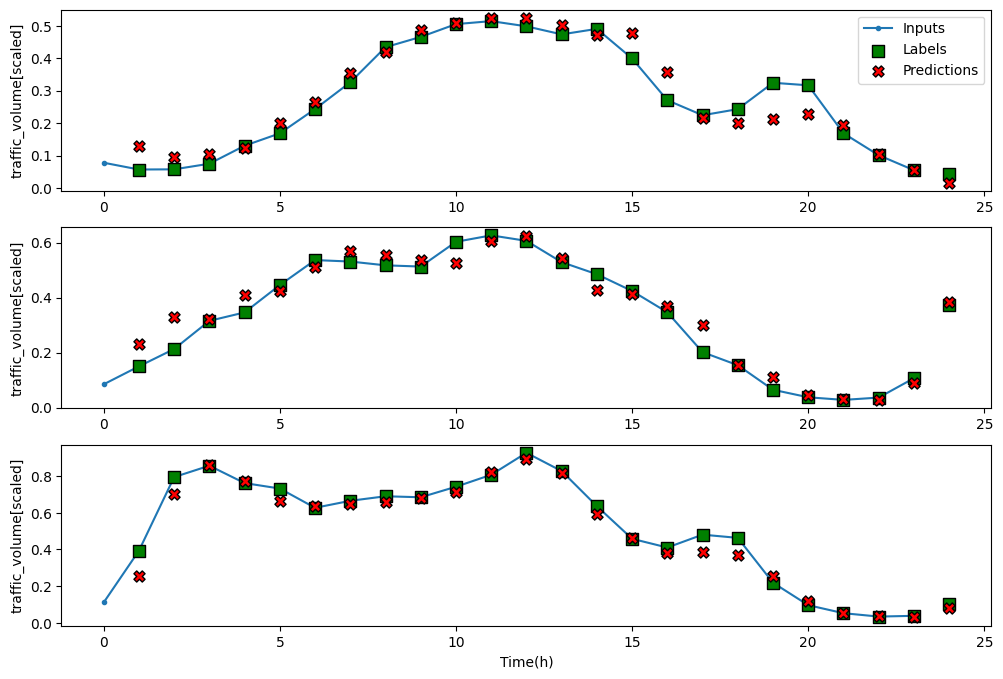

In [12]:
# valデータとtestデータの評価
val_loss = evaluate(model, val_dataloader, val_criterion, device)
test_loss = evaluate(model, test_dataloader, val_criterion, device)

print(f'Validation MAE: {val_loss:.4f}')
print(f'Test MAE: {test_loss:.4f}')

# 予測値の可視化
wide_window.plot(model)

### 15.3.2 LSTMをマルチステップモデルとして実装する

In [13]:
# マルチステップモデル用のデータウィンドウの作成（24時間分の入力から次の24時間の交通量を予測するモデル）
multi_window = DataWindow(
    input_width=24,
    label_width=24,
    shift=24,
    train_df=train_df,
    val_df=val_df,
    test_df=test_df,
    label_columns=['traffic_volume']
)

In [14]:
# dataloaderの作成
train_dataloader = multi_window.train
val_dataloader = multi_window.val
test_dataloader = multi_window.test

# モデルの訓練
model = LSTMModel(
    input_dim=input_dim,
    output_dim=output_dim_single,
    hidden_dim=hidden_dim
)
optimizer = optim.Adam(model.parameters(), lr=0.001)
history = compile_and_fit(model, 
                          train_dataloader, 
                          val_dataloader, 
                          loss_criterion, 
                          optimizer,
                          device,
                          max_epochs=50,
                          patience=3
)

Epoch 1/50, Train Loss: 0.0372, Val Loss: 0.0188
Epoch 2/50, Train Loss: 0.0159, Val Loss: 0.0172
Epoch 3/50, Train Loss: 0.0149, Val Loss: 0.0166
Epoch 4/50, Train Loss: 0.0144, Val Loss: 0.0161
Epoch 5/50, Train Loss: 0.0141, Val Loss: 0.0157
Epoch 6/50, Train Loss: 0.0138, Val Loss: 0.0157
Epoch 7/50, Train Loss: 0.0136, Val Loss: 0.0152
Epoch 8/50, Train Loss: 0.0134, Val Loss: 0.0151
Epoch 9/50, Train Loss: 0.0131, Val Loss: 0.0146
Epoch 10/50, Train Loss: 0.0130, Val Loss: 0.0147
Epoch 11/50, Train Loss: 0.0128, Val Loss: 0.0147
Epoch 12/50, Train Loss: 0.0127, Val Loss: 0.0148
Early stopping triggered


Validation MAE: 0.0812
Test MAE: 0.0653


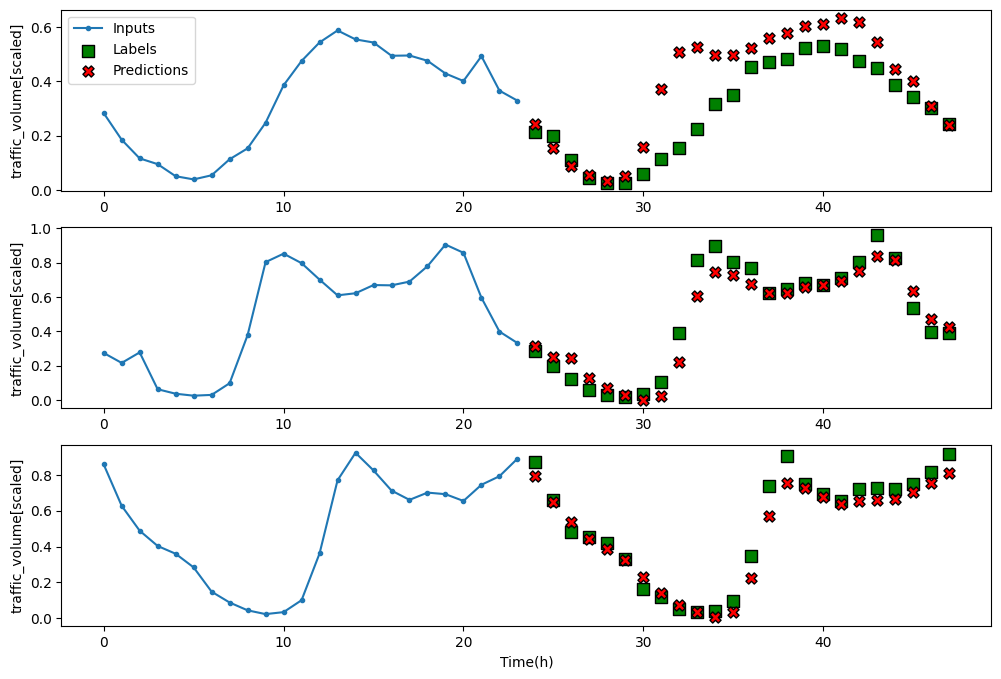

In [15]:
# valデータとtestデータの評価
val_loss = evaluate(model, val_dataloader, val_criterion, device)
test_loss = evaluate(model, test_dataloader, val_criterion, device)

print(f'Validation MAE: {val_loss:.4f}')
print(f'Test MAE: {test_loss:.4f}')

# 予測値の可視化
multi_window.plot(model)

### 15.3.3 LSTMを多出力モデルとして実装する

In [16]:
# プロット時に可視化できるモデルの予測値の数を増やすために、より広いウィンドウも定義
mo_wide_window = DataWindow(
    input_width=24, 
    label_width=24, 
    shift=1, 
    train_df=train_df,
    val_df=val_df,
    test_df=test_df,
    label_columns=['temp', 'traffic_volume']
)

In [19]:
# dataloaderの作成
train_dataloader = mo_wide_window.train
val_dataloader = mo_wide_window.val
test_dataloader = mo_wide_window.test

# モデルの訓練
model = LSTMModel(
    input_dim=input_dim,
    output_dim=output_dim_multi,
    hidden_dim=hidden_dim
)
optimizer = optim.Adam(model.parameters(), lr=0.001)
history = compile_and_fit(model, 
                          train_dataloader, 
                          val_dataloader, 
                          loss_criterion, 
                          optimizer,
                          device,
                          max_epochs=50,
                          patience=3
)

Epoch 1/50, Train Loss: 0.0464, Val Loss: 0.0112
Epoch 2/50, Train Loss: 0.0064, Val Loss: 0.0043
Epoch 3/50, Train Loss: 0.0037, Val Loss: 0.0030
Epoch 4/50, Train Loss: 0.0030, Val Loss: 0.0025
Epoch 5/50, Train Loss: 0.0027, Val Loss: 0.0022
Epoch 6/50, Train Loss: 0.0025, Val Loss: 0.0021
Epoch 7/50, Train Loss: 0.0023, Val Loss: 0.0019
Epoch 8/50, Train Loss: 0.0022, Val Loss: 0.0018
Epoch 9/50, Train Loss: 0.0021, Val Loss: 0.0018
Epoch 10/50, Train Loss: 0.0020, Val Loss: 0.0016
Epoch 11/50, Train Loss: 0.0019, Val Loss: 0.0015
Epoch 12/50, Train Loss: 0.0018, Val Loss: 0.0015
Epoch 13/50, Train Loss: 0.0017, Val Loss: 0.0014
Epoch 14/50, Train Loss: 0.0017, Val Loss: 0.0014
Epoch 15/50, Train Loss: 0.0016, Val Loss: 0.0013
Epoch 16/50, Train Loss: 0.0016, Val Loss: 0.0013
Epoch 17/50, Train Loss: 0.0016, Val Loss: 0.0013
Epoch 18/50, Train Loss: 0.0015, Val Loss: 0.0012
Epoch 19/50, Train Loss: 0.0015, Val Loss: 0.0012
Epoch 20/50, Train Loss: 0.0015, Val Loss: 0.0012
Epoch 21/

Validation MAE: 0.0208
Test MAE: 0.0181


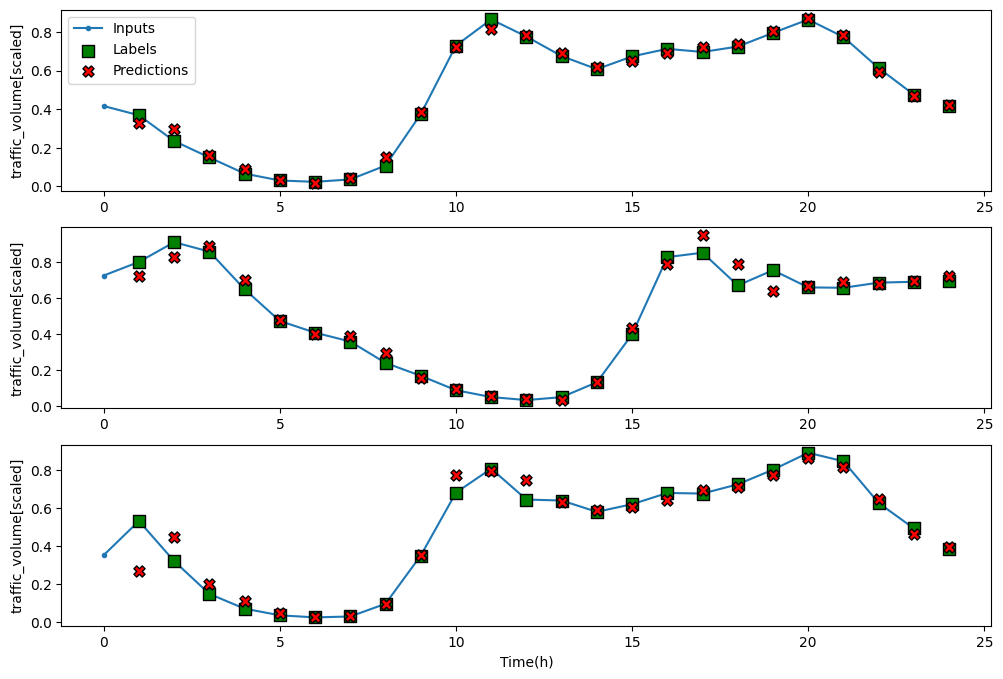

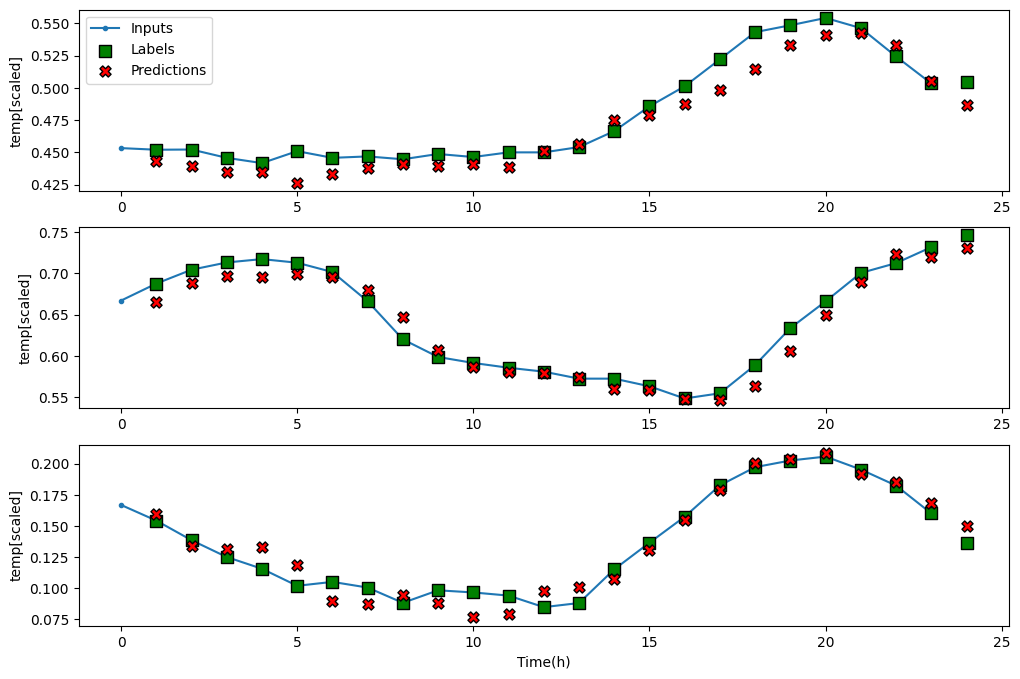

In [21]:
# valデータとtestデータの評価
val_loss = evaluate(model, val_dataloader, val_criterion, device)
test_loss = evaluate(model, test_dataloader, val_criterion, device)

print(f'Validation MAE: {val_loss:.4f}')
print(f'Test MAE: {test_loss:.4f}')

# 予測値の可視化
mo_wide_window.plot(model)
mo_wide_window.plot(model, plot_col='temp')